# ***Energy estimation:***
$$ E_{total} = E_{comp} + E_{DM}$$
$$E_{comp} = N_{MAC} \times e_{MAC}$$
$$
E_{D M}=\sum_{i \in S_{\text {Memory }}} \sum_{j \in\{I, O, W\}} N_{D M_{i, j}}, \times e_{D M_{i, j}}
$$
We can estimate energy for different type of data (Input, Output, Weight) and for memory hierarchy $S_{\text {Memory }}=\{D R A M \rightarrow G B, G B \rightarrow N o C, N o C \rightarrow RF, RF \rightarrow MAC\}$ 

The key challenge is to find $N_{D M_{i, j}}$ which depends on the DNN model, hardware architecture, and dataflow

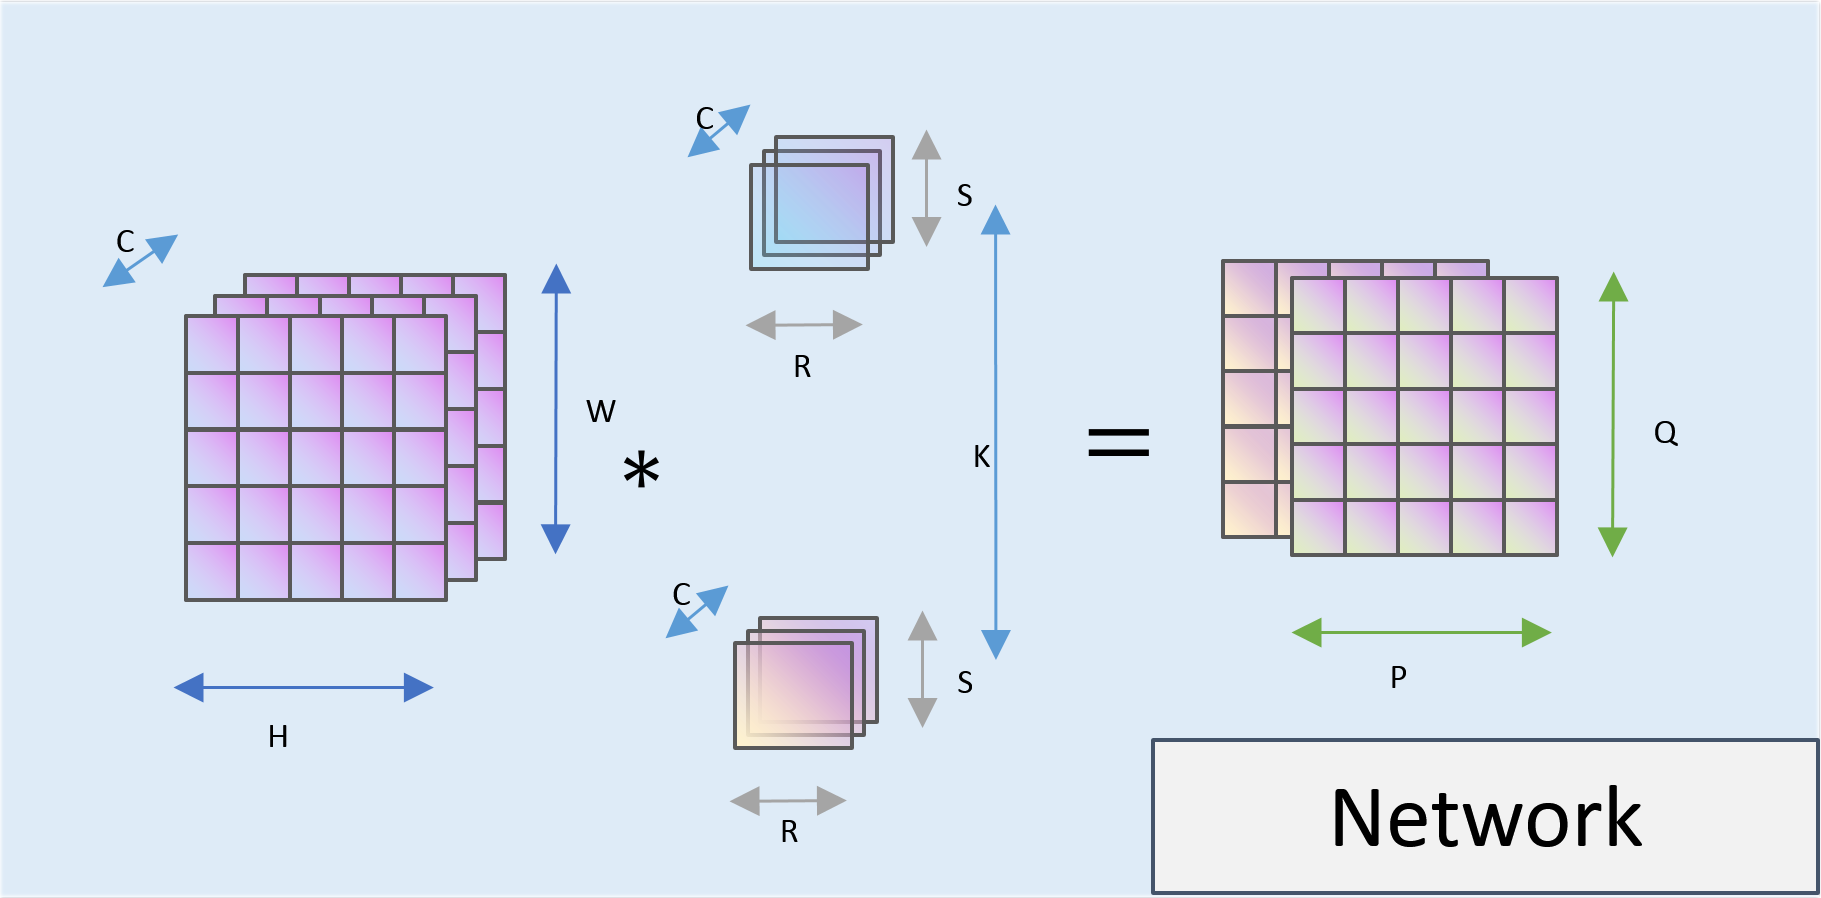

![picture](https://eyeriss.mit.edu/images/architecture.png)


Nested loop illustration
```c
//DRAM level
for c = [0:C]:
  //Global buffer level
  for p = [0:P]:
    for k = [0:K]:
      //NoC level
      for q = [0:Q]:
        //RF level
        for r = [0:R]:
          for s = [0:S]:
            Output[p][q][k] +=
              Weight[r][s][k][c]*
              Input[p+r][q+s][c]  
```




# Let's Test Some Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

*Load data*

In [ ]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


*Generate .yaml files for each Architecture*

In [ ]:
def yaml_generator(i,c,k,p,r):
  with open('VGG02_layer5.yaml','r') as file:
    txt = file.read()
    txt_new = txt.replace('$c$',str(c))
    txt_new = txt_new.replace('$k$',str(k))
    txt_new = txt_new.replace('$p$',str(p))
    txt_new = txt_new.replace('$r$',str(r))
    with open('file/CNN'+str(i)+'.yaml','w') as output:
      output.write(txt_new)

In [ ]:
i = 0
j = 0
for l in range(2):
  if(l==1):
    print("____________Two layer CNN____________")
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          i+=1
          j+=1
          print(str(j)+"- Layer1: c="+str(1)+" k="+str(k1)+" p=q="+str(28)+" r=s="+str(r)+"-->CNN"+str(i))
          i+=1
          print("  - Layer2: c="+str(k1)+" k="+str(k2)+" p=q="+str(14)+" r=s="+str(r)+"-->CNN"+str(i))
          print("-------------------")
        
  else:
    print("____________One layer CNN____________")
    for k in range(8,33,8):
      for r in range(3,8,2):
        i+=1
        j+=1
        print(str(j)+"- Layer1: c="+str(1)+" k="+str(k)+" p=q="+str(28)+" r=s="+str(r)+"-->CNN"+str(i))
        print("-------------------")

____________One layer CNN____________
1- Layer1: c=1 k=8 p=q=28 r=s=3-->CNN1
-------------------
2- Layer1: c=1 k=8 p=q=28 r=s=5-->CNN2
-------------------
3- Layer1: c=1 k=8 p=q=28 r=s=7-->CNN3
-------------------
4- Layer1: c=1 k=16 p=q=28 r=s=3-->CNN4
-------------------
5- Layer1: c=1 k=16 p=q=28 r=s=5-->CNN5
-------------------
6- Layer1: c=1 k=16 p=q=28 r=s=7-->CNN6
-------------------
7- Layer1: c=1 k=24 p=q=28 r=s=3-->CNN7
-------------------
8- Layer1: c=1 k=24 p=q=28 r=s=5-->CNN8
-------------------
9- Layer1: c=1 k=24 p=q=28 r=s=7-->CNN9
-------------------
10- Layer1: c=1 k=32 p=q=28 r=s=3-->CNN10
-------------------
11- Layer1: c=1 k=32 p=q=28 r=s=5-->CNN11
-------------------
12- Layer1: c=1 k=32 p=q=28 r=s=7-->CNN12
-------------------
____________Two layer CNN____________
13- Layer1: c=1 k=8 p=q=28 r=s=3-->CNN13
  - Layer2: c=8 k=8 p=q=14 r=s=3-->CNN14
-------------------
14- Layer1: c=1 k=8 p=q=28 r=s=5-->CNN15
  - Layer2: c=8 k=8 p=q=14 r=s=5-->CNN16
-----------------

In [ ]:
i = 0
for l in range(2):
  if(l==1):
    #-----------Two layer CNN-----------
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          i+=1
          yaml_generator(i,1,k1,28,r)
          i+=1
          yaml_generator(i,k1,k2,14,r)
        
  else:
    #-----------One layer CNN-----------
    for k in range(8,33,8):
      for r in range(3,8,2):
        i+=1
        yaml_generator(i,1,k,28,r)

In [ ]:
!zip -r file.zip file

*Compile and Train each architecture and save the test accuracy*

In [ ]:
i = 0
acc = np.zeros(26)
for l in range(2):
  if(l==1):
    #-----------Two layer CNN-----------
    for k1 in range(8,17,8):
      for k2 in range(k1,33,8):
        for r in range(3,6,2):  
          model = keras.Sequential(
            [
              keras.Input(shape=input_shape),
              layers.Conv2D(k1, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Conv2D(k2, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Flatten(),
              layers.Dropout(0.5),
              layers.Dense(num_classes, activation="softmax"),
            ]
          )
          batch_size = 128
          epochs = 10
          model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
          model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
          score = model.evaluate(x_test, y_test, verbose=0)
          acc[i] = score[1]
          i+=1
          
          
        
  else:
    #-----------One layer CNN-----------
    for k in range(8,33,8):
      for r in range(3,8,2):
        model = keras.Sequential(
            [
              keras.Input(shape=input_shape),
              layers.Conv2D(k, kernel_size=(r, r), padding='same', activation="relu"),
              layers.MaxPooling2D(pool_size=(2, 2)),
              layers.Flatten(),
              layers.Dropout(0.5),
              layers.Dense(num_classes, activation="softmax"),
             ] 
        )
        batch_size = 128
        epochs = 10
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
        score = model.evaluate(x_test, y_test, verbose=0)
        acc[i] = score[1]
        i+=1


In [ ]:
#save array
from numpy import savetxt
# save to csv file
savetxt('ACC_res.csv', acc, delimiter=',')

Plot the results :)

In [ ]:
# load numpy array from csv file
from numpy import loadtxt

acc = loadtxt('ACC_res.csv', delimiter=',')
enj_res = loadtxt('ENJ_res.csv', delimiter=',')
enj = enj_res[:,2]
lat = enj_res[:,1]
#print(acc.shape, enj.shape)
norm_acc = np.linalg.norm(acc)
normal_acc = acc/norm_acc
norm_enj = np.linalg.norm(enj)
normal_enj = enj/norm_enj


In [ ]:
def plot_scatter(x,y,x_label, y_label):
  color = np.zeros(x.shape)
  for i in range(x.shape[0]):
    j=0
    while((y[i]>=y[j] or x[i]<=x[j]) and j<x.shape[0]-1):
      j+=1
    if(j<25):
      color[i] = 1

  l = np.arange(x.shape[0])
  plt.figure(figsize=(10, 8))
  plt.scatter(x, y, marker='x',c=color)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  for i, txt in enumerate(l):
    plt.annotate(txt, (x[i], y[i]))

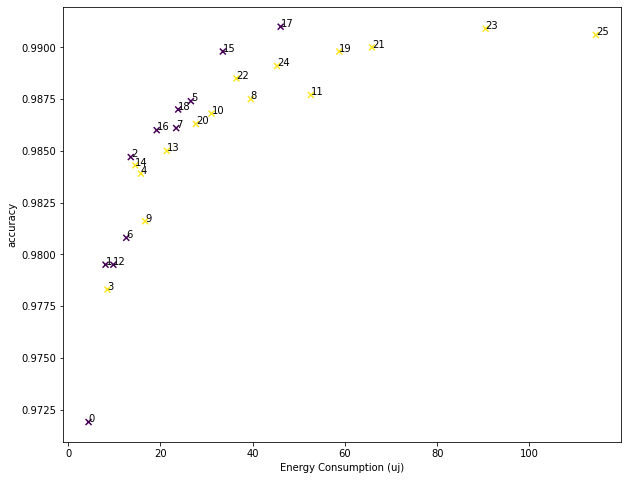

In [ ]:
plot_scatter(enj,acc,"Energy Consumption (uj)","accuracy")

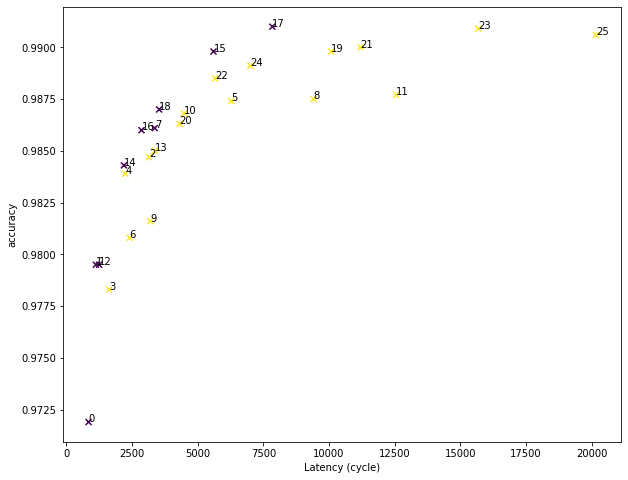

In [ ]:
plot_scatter(lat,acc,"Latency (cycle)","accuracy")

# Conclusion

1.   **Search Space?**
        *   DNN Hyperparameters
        *   Accelerator Parameters (Size of GLB, SoC, RF memory, # of PEs, bandwidth, Technology, Supply voltage, ...) 


2.   **Searching Strategy?**
        *   Bayesian
        *   Evolutionary 
        *   Random search
        *   NAS
        
        




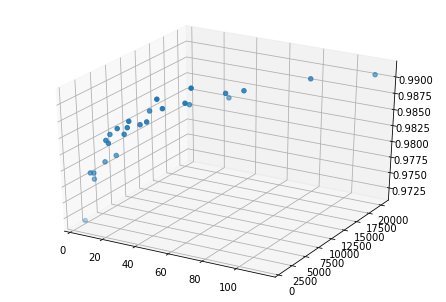

In [ ]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(enj, lat, acc)
ax.
pyplot.show()

# Fun
Let's find what is the relation between accurcy and number of neurons in hidden layer

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28

# Flatten the images
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) #.reshape((-1, 784))
x_test = x_test.reshape(x_test.shape[0], image_vector_size)

print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training data shape:  (60000, 784)
Test data shape (10000, 784)


In [ ]:
ACC_N = np.zeros((56))
idx = 0
for n in range(16,128,2):
  
  model = Sequential()
  model.add(InputLayer([image_size]))
  model.add(Dense(units=n, activation='sigmoid')) #, input_shape=(image_size,)
  model.add(Dense(units=num_classes, activation='softmax'))
  model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=False, validation_split=.1)
  loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
  ACC_N[idx] = accuracy
  idx += 1
  

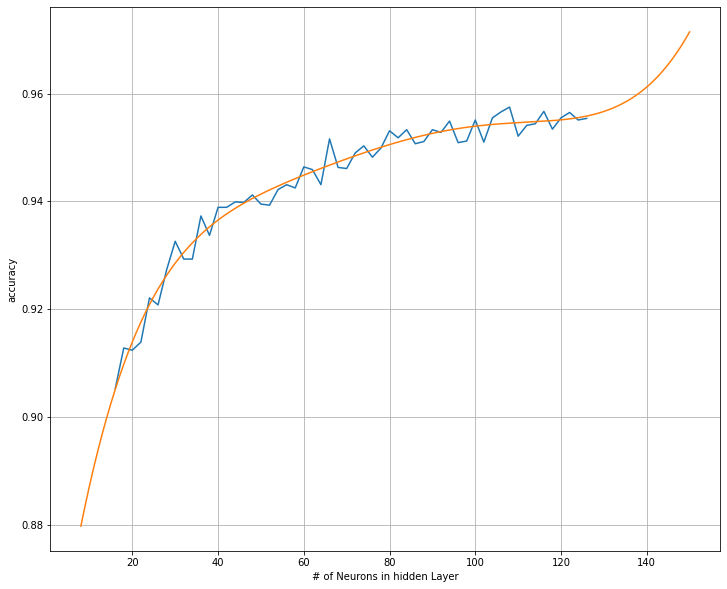

In [ ]:
z = np.polyfit(np.arange(16,128,2), ACC_N, 6)
p = np.poly1d(z)
xp = np.linspace(8, 150, 1000)

plt.figure(figsize=(12, 10))
plt.plot(np.arange(16,128,2), ACC_N)
plt.plot(xp, p(xp),'-')
plt.xlabel("# of Neurons in hidden Layer")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [ ]:
for layer in model.layers:
	# check for convolutional layer
  #print(layer.name)
  if 'conv' not in layer.name:
    #print (layer.name)
    continue
	# get filter weights
  filters, biases = layer.get_weights()
  #print(layer.name, layer.input)
  print(layer.name)
  s = filters.shape[0]
  r = filters.shape[1]
  c = filters.shape[2]
  k = filters.shape[3]
  q = layer.output.shape[1]
  p = layer.output.shape[2]
  MAC = s*r*c*k*p*q
  print("input shape: ", layer.input.shape)
  print("filter shape: ", filters.shape)
  print("output shape: ", layer.output.shape)
  print("# of MACs: ", MAC)

'for train, test in kfold.split(x, y):\n  print(x[train])\n  print("---------------")\n  print(x[test])\n  print("----------------------------------------------")'

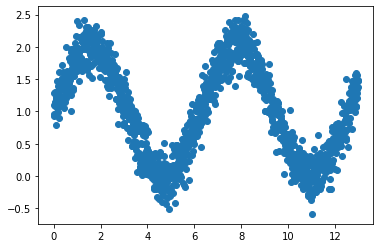

In [ ]:
from sklearn.model_selection import KFold
x = np.arange(0,13,0.01)
y = np.sin(x)+np.random.normal(0,0.2,x.shape)+np.ones(x.shape)
plt.scatter(x,y)
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation
'''for train, test in kfold.split(x, y):
  print(x[train])
  print("---------------")
  print(x[test])
  print("----------------------------------------------")'''


In [ ]:
x_train = x[np.arange(x.shape[0])%5!=0]
y_trian = y[np.arange(x.shape[0])%5!=0]
x_test = x[np.arange(x.shape[0])%5==0]
y_test = y[np.arange(x.shape[0])%5==0]

In [ ]:
model = Sequential()
#model.add(InputLayer(x.shape))
model.add(Dense(units=10, activation='sigmoid')) #, input_shape=(image_size,)
model.add(Dense(units=1, activation='softmax'))
model.compile(optimizer="sgd", loss='MeanSquaredError', metrics=['accuracy'])
model.fit(x_train, y_trian, batch_size=128, epochs=4, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras.regularizers import L1L2

inputs = Input(shape=(1,))
preds = Dense(10,activation='sigmoid')(inputs)
preds = Dense(20,activation='sigmoid')(preds)
preds = Dense(10,activation='sigmoid')(preds)
preds = Dense(1,activation='sigmoid')(preds)


model = Model(inputs=inputs,outputs=preds)
sgd=keras.optimizers.SGD()
model.compile(optimizer="sgd",loss='mse',metrics=['mse'])
#model.fit(x,y, batch_size=1, epochs=30, shuffle=False)
model.fit(x_train, y_trian, batch_size=30, epochs=100, verbose=False, validation_split=.1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
num_folds = 5
X, y = load_iris(return_X_y=True)
for i in range(num_folds):
  x_train = X[np.arange(150)%num_folds!=i]
  y_trian = y[np.arange(150)%num_folds!=i]
  x_test = X[np.arange(150)%num_folds==i]
  y_test = y[np.arange(150)%num_folds==i]
  clf = LogisticRegression(random_state=0).fit(x_train, y_trian)
  print(clf.score(x_test, y_test))


array([1.5625, 0.5625, 0.5625, 1.5625, 0.0625, 0.0625])

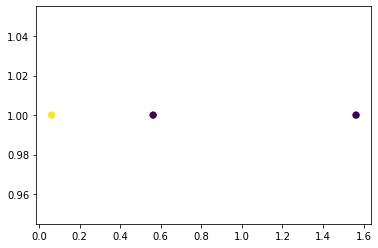

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def phi(x):
  r = (x-1.5*np.ones(6))**2
  return r

x1 = [0.25, 0.75, 2.25, 2.75, 1.25, 1.75]
y = np.ones(6)
c = [0,0,0,0,1,1]
#plt.scatter(x1,y,c=c)
x = phi(x1)
plt.scatter(x,y,c=c)
x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


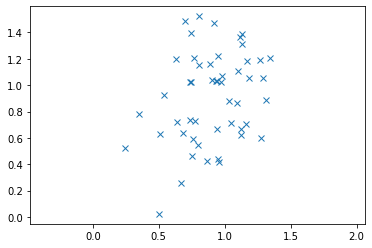

In [ ]:
mean = [1, 1]
cov = [[0.1, 0.1], [0, 0.1]]
x, y = np.random.multivariate_normal(mean, cov, 50).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  del sys.path[0]


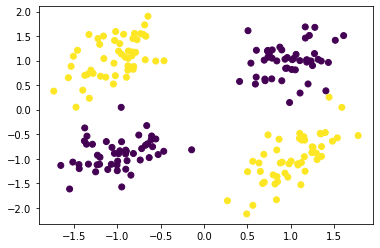

In [ ]:
x1, x2 = np.random.multivariate_normal([1,1], cov, 50).T
c1 = np.zeros(50)
x, y = np.random.multivariate_normal([-1,1], cov, 50).T
c = np.ones(50)
x1 = np.concatenate((x1,x))
x2 = np.concatenate((x2,y))
c1 = np.concatenate((c1,c))
x, y = np.random.multivariate_normal([-1,-1], cov, 50).T
c = np.zeros(50)
x1 = np.concatenate((x1,x))
x2 = np.concatenate((x2,y))
c1 = np.concatenate((c1,c))
x, y = np.random.multivariate_normal([1,-1], cov, 50).T
c = np.ones(50)
x1 = np.concatenate((x1,x))
x2 = np.concatenate((x2,y))
c1 = np.concatenate((c1,c))


plt.scatter(x1,x2,c=c1)

In [ ]:
np.reshape(x,(50,2))

ValueError: ignored